# Instituto Tecnológico de Estudios Superiores de Monterrey
## Vision Computacional (Grupo 10)
### Alumnos:
- **[A01330566]**  Ramon Ariel Ivan Muñoz Corona
- **[A00453954]**  Luis Fernando Rios Piedra
- **[A00174183]**  Rodrigo Eugenio Ortiz Fernandez
- **[A01687370]**  Fredy Reyes Sanchez
- **[A00529676]**  Rafael Sergio Garcia Martinez

# 6. Otsu Thresholding

## Table of Contents
1. [Libraries](#libraries)
2. [Single Thresholding](#single)
3. [Multi Thresholding](#multi)
4. [Preguntas](#preg)

Thresholding is used to create a binary image from a grayscale image

## Importing Libraries <a class="anchor" id="libraries" ></a>

In [1]:
import matplotlib.pyplot as plt
from skimage import data
from skimage.filters import threshold_otsu
from skimage.filters import threshold_multiotsu
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Single Thresholding <a class="anchor" id="single" ></a>

We illustrate how to apply one of these thresholding algorithms.
Otsu's method [2]_ calculates an "optimal" threshold (marked by a red line in the
histogram below) by maximizing the variance between two classes of pixels,
which are separated by the threshold. Equivalently, this threshold minimizes
the intra-class variance.

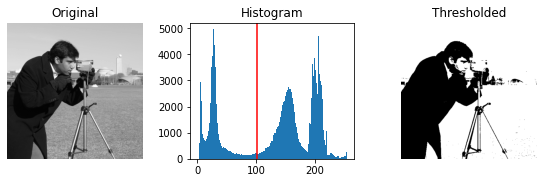

In [2]:
image = data.camera()
thresh = threshold_otsu(image)
binary = image > thresh

fig, axes = plt.subplots(ncols=3, figsize=(10, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

If you are not familiar with the details of the different algorithms and the
underlying assumptions, it is often difficult to know which algorithm will give
the best results. Therefore, Scikit-image includes a function to evaluate
thresholding algorithms provided by the library. At a glance, you can select
the best algorithm for your data without a deep understanding of their
mechanisms.




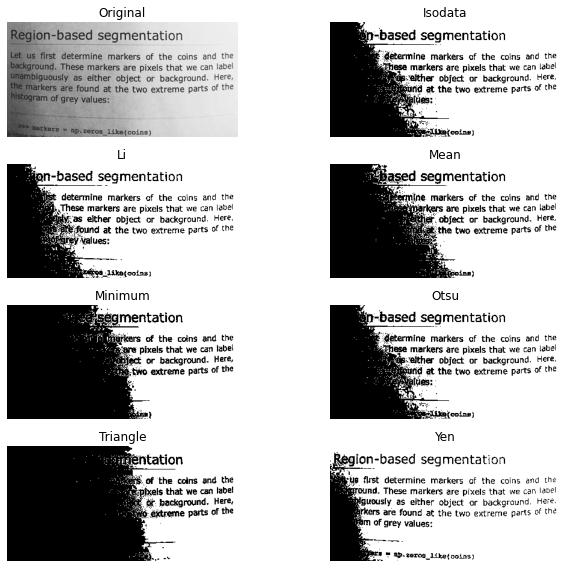

In [3]:
from skimage.filters import try_all_threshold

img = data.page()

fig, ax = try_all_threshold(img, figsize=(10, 8), verbose=False)
plt.show()

In [4]:
# TODO: Slide image for segmentation, alpha blending
import cv2
import numpy as np
import math
from PIL import Image

##################################
## SLIDE FOR IMAGE SEGMENTATION ##
##################################
import cv2
import numpy as np

def pltImgs(imgArr,stTitles, cols = 5, win_height = 5, win_len = 0):
  rows = int(math.ceil(len(imgArr) / cols))
  if win_len == 0: win_len = win_height*cols
  fig = plt.figure(figsize=(win_len, win_height))
  for i in range(0,len(imgArr)):
    a=fig.add_subplot(rows,cols,i+1)
    imgplot = plt.imshow(imgArr[i])
    a.set_title(stTitles[i])
  
  plt.show()

def sliding_window(image, step_size, window_size):
  # slide a window across the image
  for y in range(0, image.shape[0] - window_size[1] + 1, step_size):
    for x in range(0, image.shape[1] - window_size[0] + 1, step_size):
      # yield the current window
      yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

def otsu_threshold(image):
  # apply Otsu's thresholding method
  _, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  return thresh

def segment_image(image_og, step_size, window_size):
  # Convert to Grayscale
  image = cv2.cvtColor(image_og, cv2.COLOR_BGR2GRAY)
  # initialize the segmented image and the alpha mask
  segmented = np.zeros_like(image)
  alpha = np.zeros_like(image)

  # slide a window over the image and segment each window
  for (x, y, window) in sliding_window(image, step_size=step_size, window_size=window_size):
      # apply OTSU thresholding to the current window
      thresh = otsu_threshold(window)

      # calculate the alpha mask for the thresholded window
      alpha_window = np.zeros_like(thresh)
      alpha_window[thresh > 0] = 255

      # add the thresholded window and alpha mask to the segmented image and alpha mask
      segmented[y:y + window_size[1], x:x + window_size[0]] += thresh
      alpha[y:y + window_size[1], x:x + window_size[0]] += alpha_window

  # normalize the alpha mask
  alpha[alpha == 0] = 1
  alpha = cv2.normalize(alpha, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

  # alpha blend the segmented image with the original image
  blended = cv2.addWeighted(image, 0.7, segmented, 0.3, 0)

  return blended, alpha

####################
## ALPHA BLEDNING ##
####################

def AlphaBlending(img1_path, img2_path, window_size = (50,50),step_size = 50):
  imgs = []
  titles = []

  # read the foreground image
  foreground = cv2.imread(img1_path)
  foreground = cv2.cvtColor(foreground, cv2.COLOR_RGB2BGR)
  imgs.append(foreground)
  titles.append("Foreground")

  foreground = cv2.medianBlur(foreground, 5)

  # read background image
  background = cv2.imread(img2_path)
  background = cv2.resize(background, (foreground.shape[1], foreground.shape[0]))
  background = cv2.cvtColor(background, cv2.COLOR_RGB2BGR)
  imgs.append(background)
  titles.append("Background")

  # segment the image and alpha blend it with the original image
  segmented_image, alpha = segment_image(foreground, step_size, window_size)
  alpha = cv2.cvtColor(alpha, cv2.COLOR_GRAY2BGR)
  imgs.append(alpha)
  titles.append("Alpha Mask")

  # Convert uint8 to float
  foreground = foreground.astype(float)
  background = background.astype(float)

  # Normalize the alpha mask to keep intensity between 0 and 1
  alpha = alpha.astype(float)/255

  # Multiply the foreground with the alpha matte
  foreground = cv2.multiply(alpha, foreground)
  
  # Multiply the background with ( 1 - alpha )
  background = cv2.multiply(1.0 - alpha, background)
  
  # Add the masked foreground and background.
  outImage = cv2.add(foreground, background)
  imgs.append(outImage/255)
  titles.append("Alpha Blending")

  pltImgs(imgs,titles)

Window Size = (50,50)	Step Size = 50


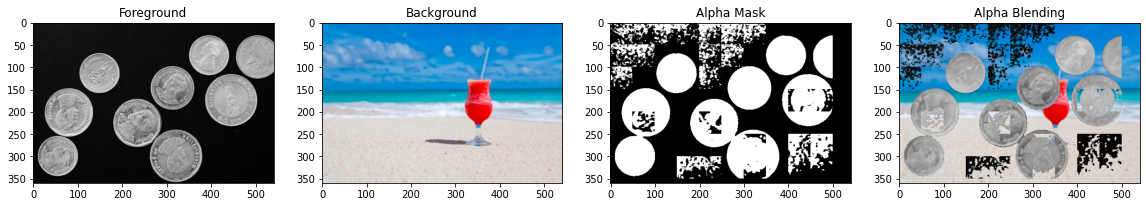

Window Size = (30,30)	Step Size = 30


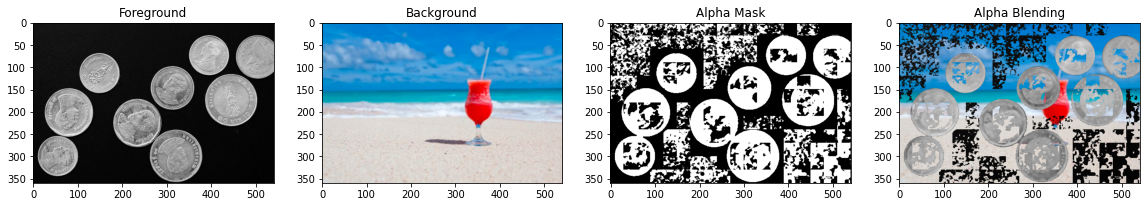

Window Size = (100,100)	Step Size = 100


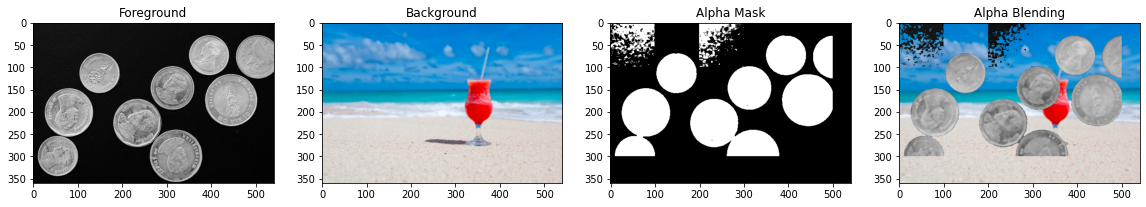

In [5]:
print("Window Size = (50,50)\tStep Size = 50")
AlphaBlending("/content/drive/MyDrive/Colab Notebooks/Vision Computacional/9.4 OTSU/data/coins.jpg", "/content/drive/MyDrive/Colab Notebooks/Vision Computacional/9.4 OTSU/data/ocean.png")
print("Window Size = (30,30)\tStep Size = 30")
AlphaBlending("/content/drive/MyDrive/Colab Notebooks/Vision Computacional/9.4 OTSU/data/coins.jpg", "/content/drive/MyDrive/Colab Notebooks/Vision Computacional/9.4 OTSU/data/ocean.png",(30,30),30)
print("Window Size = (100,100)\tStep Size = 100")
AlphaBlending("/content/drive/MyDrive/Colab Notebooks/Vision Computacional/9.4 OTSU/data/coins.jpg", "/content/drive/MyDrive/Colab Notebooks/Vision Computacional/9.4 OTSU/data/ocean.png",(100,100),100)

## Multi Thresholding <a class="anchor" id="multi" ></a>

The multi-Otsu threshold  is a thresholding algorithm that is used to separate
the pixels of an input image into several different classes, each one obtained
according to the intensity of the gray levels within the image.

Multi-Otsu calculates several thresholds, determined by the number of desired
classes. The default number of classes is 3: for obtaining three classes, the
algorithm returns two threshold values. They are represented by a red line in
the histogram below.

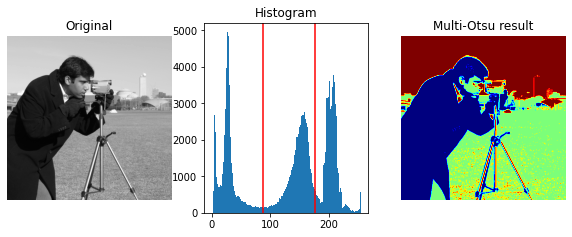

In [6]:
# The input image.
image = data.camera()

# Applying multi-Otsu threshold for the default value, generating
# three classes.
thresholds = threshold_multiotsu(image)

# Using the threshold values, we generate the three regions.
regions = np.digitize(image, bins=thresholds)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

# Plotting the original image.
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(image.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()

plt.show()

## Preguntas <a class="anchor" id="preg" ></a>

1. Experimenta con diferentes imagenes ademas de las provistas en el Colab, identifca imagenes con diferentes backgrounds y estilos, cuales son las limitaciones de single thresholding contra el algoritmo de Otsu

  El método de single thresholding es un proceso más manual ya que requiere el usuario seleccione manualmente el threshold, lo que lo puede hacer subjetivo ya que depende de de cada imagen. 

  Por otro lado, OTSU es una técnica automatizada que selecciona el threshold óptimo en función del histograma de la imagen. Este método minimiza la variación intraclase entre las regiones del foreground y del fondo, lo que lo hace más robusto y eficiente para la segmentación de imágenes. 

  En resumen, el método de Single Threshold es adecuado para imágenes simples con iluminación y fondo consistentes, mientras que el método de Otsu es más efectivo cuando se procesan imágenes más complejas con condiciones variables.

2. Como en un proyecto previo, es posible aplicar Otsu para ventanas de diferentes tamaños, obteniendo mejores resultados. Realiza esta implementacion y ve como mejoran los resultados con el ejemplo de la hoja de papel.

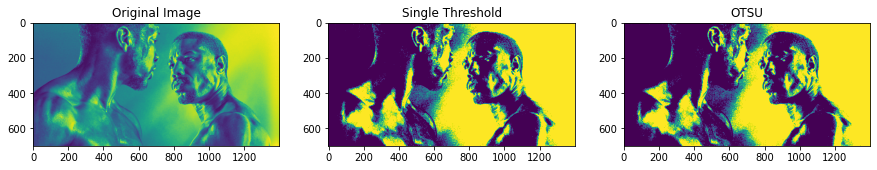

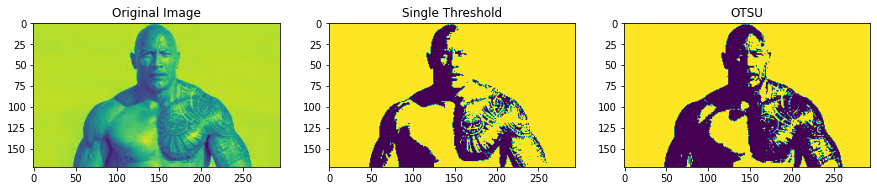

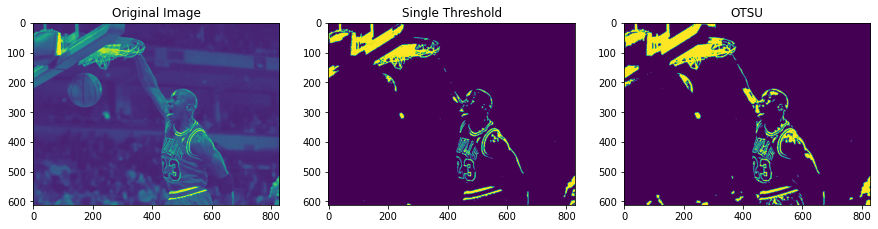

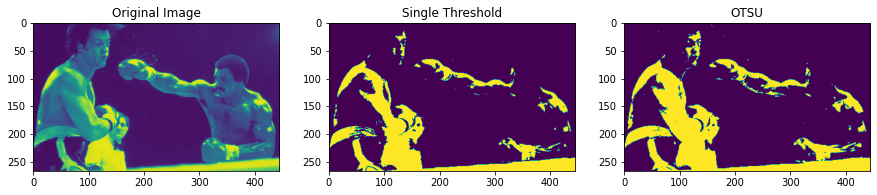

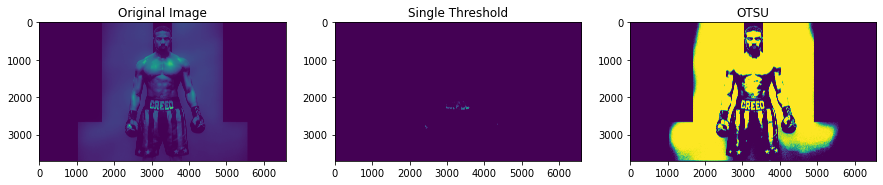

In [10]:
##############################
## SINGLE THRESHOLD VS OTSU ##
##############################

import cv2

images = ["/content/drive/MyDrive/Colab Notebooks/Vision Computacional/9.4 OTSU/data/creed.jpeg","/content/drive/MyDrive/Colab Notebooks/Vision Computacional/9.4 OTSU/data/rock.jpg","/content/drive/MyDrive/Colab Notebooks/Vision Computacional/9.4 OTSU/data/jordan.jpg","/content/drive/MyDrive/Colab Notebooks/Vision Computacional/9.4 OTSU/data/apollo.jpg","/content/drive/MyDrive/Colab Notebooks/Vision Computacional/9.4 OTSU/data/creed_III.jpg"]

for img_ in images:

  # Load the image in grayscale
  img = cv2.imread(img_, 0)

  # Apply a fixed threshold to separate foreground and background pixels
  thresh_value = 128
  ret, sing_thresh = cv2.threshold(img, thresh_value, 255, cv2.THRESH_BINARY)

  # Apply Otsu's thresholding
  ret, OTSU_thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

  pltImgs([img,sing_thresh,OTSU_thresh],["Original Image","Single Threshold","OTSU"],3,5)

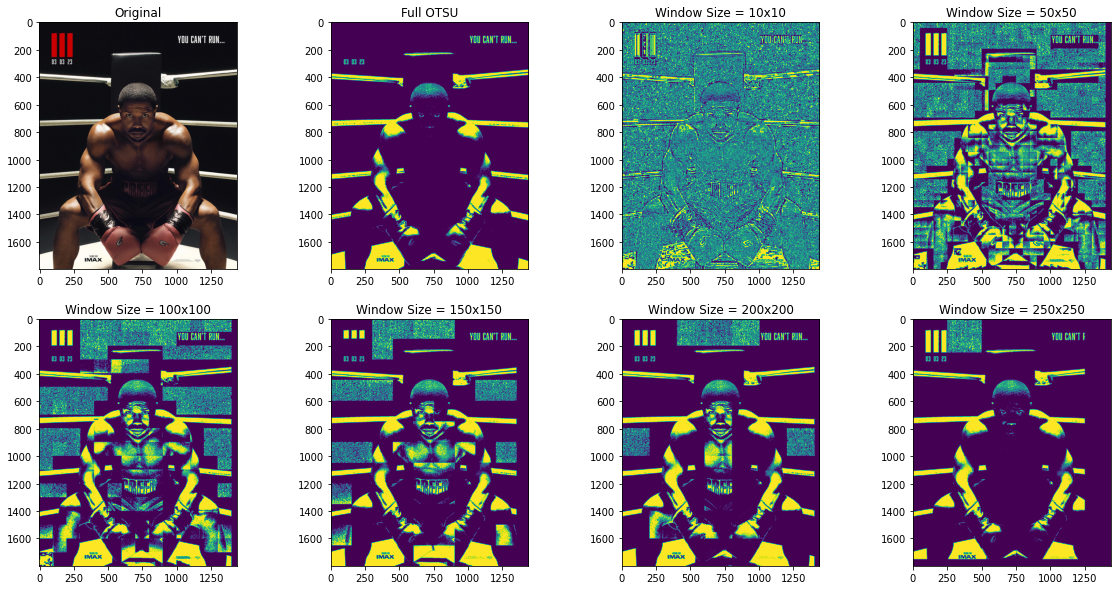

In [8]:
#########################
## SLIDING WINDOW OTSU ##
#########################

wins = [10,50,100,150,200,250]
img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/Vision Computacional/9.4 OTSU/data/creed.jpg")
imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB)]
titles = ["Original"]
# Apply Otsu's thresholding
ret, OTSU_thresh = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
imgs.append(OTSU_thresh)
titles.append("Full OTSU")
for win in wins:
  segmented_image, alpha = segment_image(img, win,(win, win))
  imgs.append(alpha)
  titles.append("Window Size = " + str(win) + "x" + str(win))

pltImgs(imgs,titles,4,10,20)


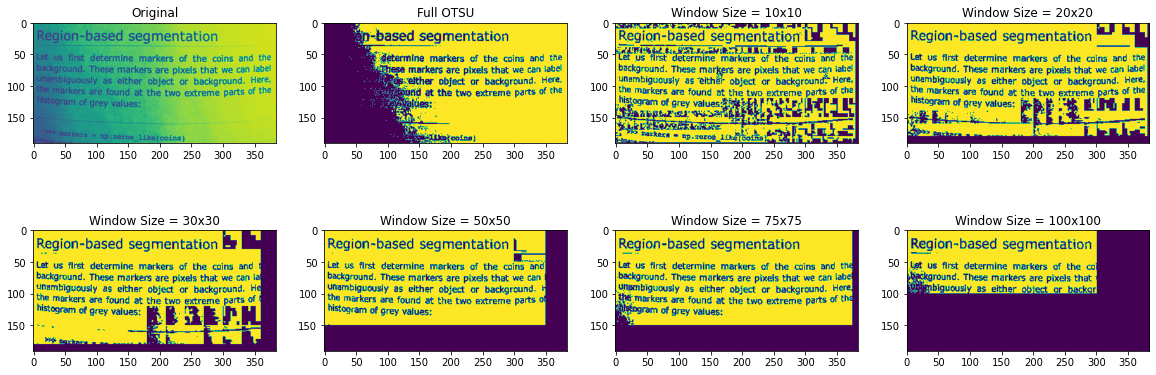

In [11]:
wins = [10,20,30,50,75,100]
img = data.page()
imgs = [img]
titles = ["Original"]
# Apply Otsu's thresholding
ret, OTSU_thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
imgs.append(OTSU_thresh)
titles.append("Full OTSU")
for win in wins:
  segmented_image, alpha = segment_image(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB), win,(win, win))
  imgs.append(alpha)
  titles.append("Window Size = " + str(win) + "x" + str(win))

pltImgs(imgs,titles,4,7,20)